# Stability anaylsis with ERA5 Ensembles

## Preliminaries
### Data boundaries
- conforming to pv anomaly detection:
- calculate climatology and set boundaries
- file at  /daten/weclip/work/blocks_era5/BLOCKS1979_2019_1.3
- **Use gh index (freva) bc. we use gh for analysis instead of pv?
- Or use pv for stability analysis instead?

**Boundaries:**
- 1940 - 2023
- NA-EUR


In [1]:
import xarray as xr
import numpy as np
import os
import xesmf as xe

input_file_path = "/net/scratch/schoelleh96/WP2/WP2.2a/ens_data/data.nc"
dataset = xr.open_dataset(input_file_path)
print(dataset)
lat_start = np.ceil(dataset.latitude.min())
lon_start = np.ceil(dataset.longitude.min())

target_lats = np.arange(float(lat_start),
                        float(dataset.latitude.max()) + 1, 1)
target_lons = np.arange(float(lon_start),
                        float(dataset.longitude.max()) + 1, 1)
print(target_lats)
print(target_lons)

/home/schoelleh96/mambaforge/envs/wp22a/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


<xarray.Dataset> Size: 42GB
Dimensions:        (number: 10, time: 31013, latitude: 141, longitude: 241)
Coordinates:
  * number         (number) int64 80B 0 1 2 3 4 5 6 7 8 9
  * time           (time) datetime64[ns] 248kB 1940-01-01T12:00:00 ... 2024-1...
    step           timedelta64[ns] 8B ...
    isobaricInhPa  float64 8B ...
  * latitude       (latitude) float64 1kB 90.0 89.5 89.0 88.5 ... 21.0 20.5 20.0
  * longitude      (longitude) float64 2kB -100.0 -99.5 -99.0 ... 19.0 19.5 20.0
    valid_time     (time) datetime64[ns] 248kB ...
Data variables:
    z              (number, time, latitude, longitude) float32 42GB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-12T09:57 GRIB to CDM+CF vi

In [5]:
target_lons.shape[0] * target_lats.shape[0]

8591

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
from matplotlib.patches import Rectangle
from scipy.signal import detrend
import glob
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import ruptures as rpt
import pandas as pd
from statsmodels.api import GLM
from statsmodels.genmod.families import Gaussian
from patsy import dmatrix
import statsmodels.api as sm
from scipy.optimize import minimize
dataPath = "../ens_data/"

In [2]:

f_path = "/daten/weclip/work/blocks_era5/BLOCKS1979_2019_1.3"
d_path = "../data/"

# Define the lat-lon box bounds
lon_min, lon_max = -100, 20  # Longitude range
lat_min, lat_max = 20, 90    # Latitude range

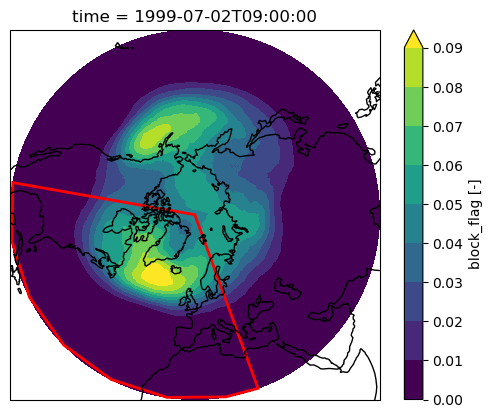

In [10]:
block_mean = xr.open_dataset(d_path + "BLOCKFLAGMEAN.nc")
p = block_mean.isel(time=0).sel(latitude=slice(20, 90))["FLAG"].plot.contourf(
    levels=np.arange(0, 0.1, 0.01), subplot_kws=dict(
        projection=ccrs.Stereographic(central_latitude=90.0, true_scale_latitude=50.0,
                                      central_longitude=0)), transform=ccrs.PlateCarree())
p.axes.coastlines()

# Create a rectangle for the box
box = Rectangle(
    (lon_min, lat_min),           # Bottom-left corner (lon, lat)
    lon_max - lon_min,            # Width (delta longitude)
    lat_max - lat_min,            # Height (delta latitude)
    linewidth=2,                  # Line thickness
    edgecolor='red',              # Border color
    facecolor='none',             # No fill
    transform=ccrs.PlateCarree()  # Ensure it aligns with map projection
)

# Add the box to the map
p.axes.add_patch(box)

## ERA5 EDA

In [2]:
ens_ds = xr.load_dataset("../ens_data/test_ens.grib", engine="cfgrib")

<xarray.Dataset> Size: 4GB
Dimensions:        (number: 10, time: 365, latitude: 361, longitude: 720)
Coordinates:
  * number         (number) int64 80B 0 1 2 3 4 5 6 7 8 9
  * time           (time) datetime64[ns] 3kB 1950-01-01T12:00:00 ... 1950-12-...
    step           timedelta64[ns] 8B 00:00:00
    isobaricInhPa  float64 8B 500.0
  * latitude       (latitude) float64 3kB 90.0 89.5 89.0 ... -89.0 -89.5 -90.0
  * longitude      (longitude) float64 6kB 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
    valid_time     (time) datetime64[ns] 3kB 1950-01-01T12:00:00 ... 1950-12-...
Data variables:
    z              (number, time, latitude, longitude) float32 4GB 5.133e+04 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:          

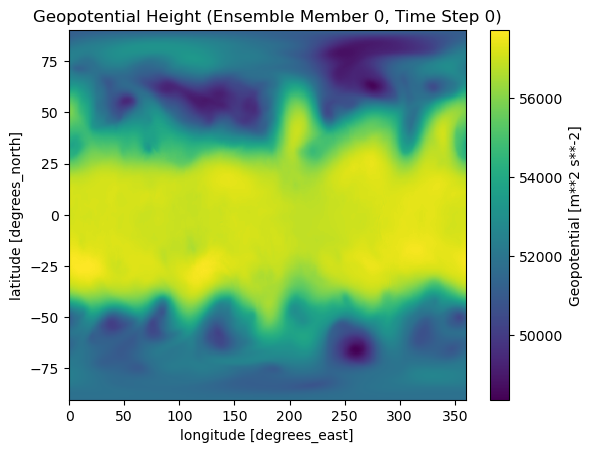

In [ ]:
# Print the dataset summary
print(ens_ds)

# Print the dimensions
print("\nDimensions:")
print(ens_ds.dims)

# Print the coordinates
print("\nCoordinates:")
print(ens_ds.coords)

# Print the data variables
print("\nData Variables:")
print(ens_ds.data_vars)

# Plot a sample of the data (e.g., the first ensemble member at the first time step)
ens_ds.isel(number=0, time=0)["z"].plot()
plt.title("Geopotential Height (Ensemble Member 0, Time Step 0)")
plt.show()

## look at spread variability

In [2]:
# Obtain all files that conform to spread_YYYY.nc in dataPath
spreadFiles = glob.glob(dataPath + "spread_*.nc")
spreadFiles.sort()
# spreadFiles = spreadFiles[1:]  # Exclude the first file if needed
years = [int(f.split('_')[-1].split('.')[0]) for f in spreadFiles]

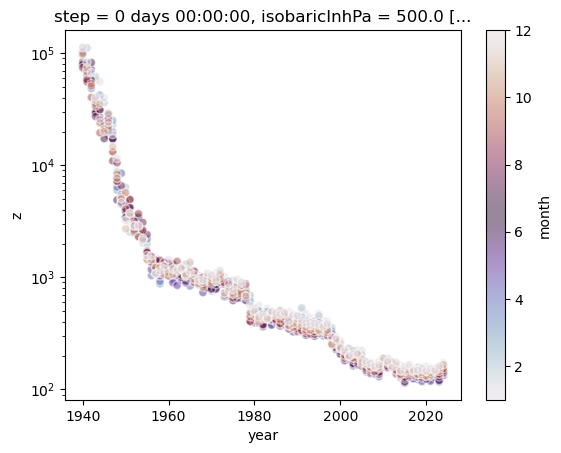

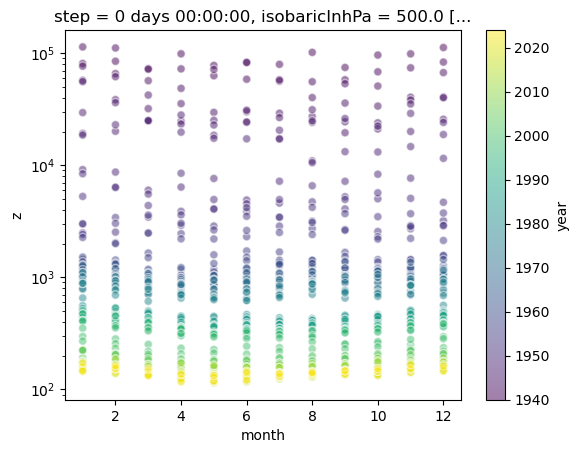

In [71]:

def loadDataset(fName):
    """Load dataset for a given file name."""
    return xr.open_dataset(fName)


def calculateMonthlyAverages(fName):
    """
    Calculate monthly averages of the variable 'z' after spatial averaging.
    Ensures the 'month' coordinate is available.
    """
    with xr.open_dataset(fName) as ds:
        return ((ds['z']).mean(dim=['latitude', 'longitude'])
                .groupby('time.month').mean(dim='time'))


def combineDatasets(datasets, years):
    """
    Combine a list of datasets into a single xarray Dataset along a new dimension 'year'.
    Adds a 'year' coordinate extracted from the time dimension of each dataset.
    """
    combined = xr.concat(
        [ds.assign_coords(year=year) for ds, year in zip(datasets, years)],
        dim='year'
    )
    return combined


def plotAverages(ds, xAxis='years'):
    """
    Plot the averages of 'z' over years or months with dynamic coloring.
    """

    if xAxis == 'years':
        cyclicColormap = plt.cm.twilight  # Choose a cyclic colormap
        norm = mcolors.Normalize(vmin=1, vmax=12)
        ds.plot.scatter(
            x='year', y='z', hue='month', yscale='log', alpha=.5,
            cmap=cyclicColormap, norm=norm, add_colorbar=True)

    elif xAxis == 'months':
        ds.plot.scatter(
            x='month', y='z', hue='year', yscale='log', alpha=.5)

    plt.show()


monthlyAverages = [calculateMonthlyAverages(fName) for fName in spreadFiles]

# Combine datasets for plotting with months on x-axis
combinedDataset = combineDatasets(monthlyAverages, years)
# combDaily = combineDatasets(datasets)
combinedDataset

# Plot averages
plotAverages(combinedDataset, xAxis='years')  # Years on x-axis
plotAverages(combinedDataset, xAxis='months')  # Months on x-axis

In [7]:
flattened_data = combinedDataset.values.flatten()

log_data = np.log(flattened_data)
# Create a corresponding time axis for the flattened data
# Repeat years for each month
years_rep = np.repeat(
    combinedDataset.coords['year'].values, combinedDataset.shape[1])
# Tile months for each year
months_rep = np.tile(
    combinedDataset.coords['month'].values, combinedDataset.shape[0])

time = np.array([f"{int(y)}-{int(m):02d}" for y,
                m in zip(years_rep, months_rep)])

Penalty: 25, Change points: [205, 470, 735, 1020]
Penalty: 40, Change points: [205, 470, 735, 1020]
Penalty: 80, Change points: [400, 700, 1020]


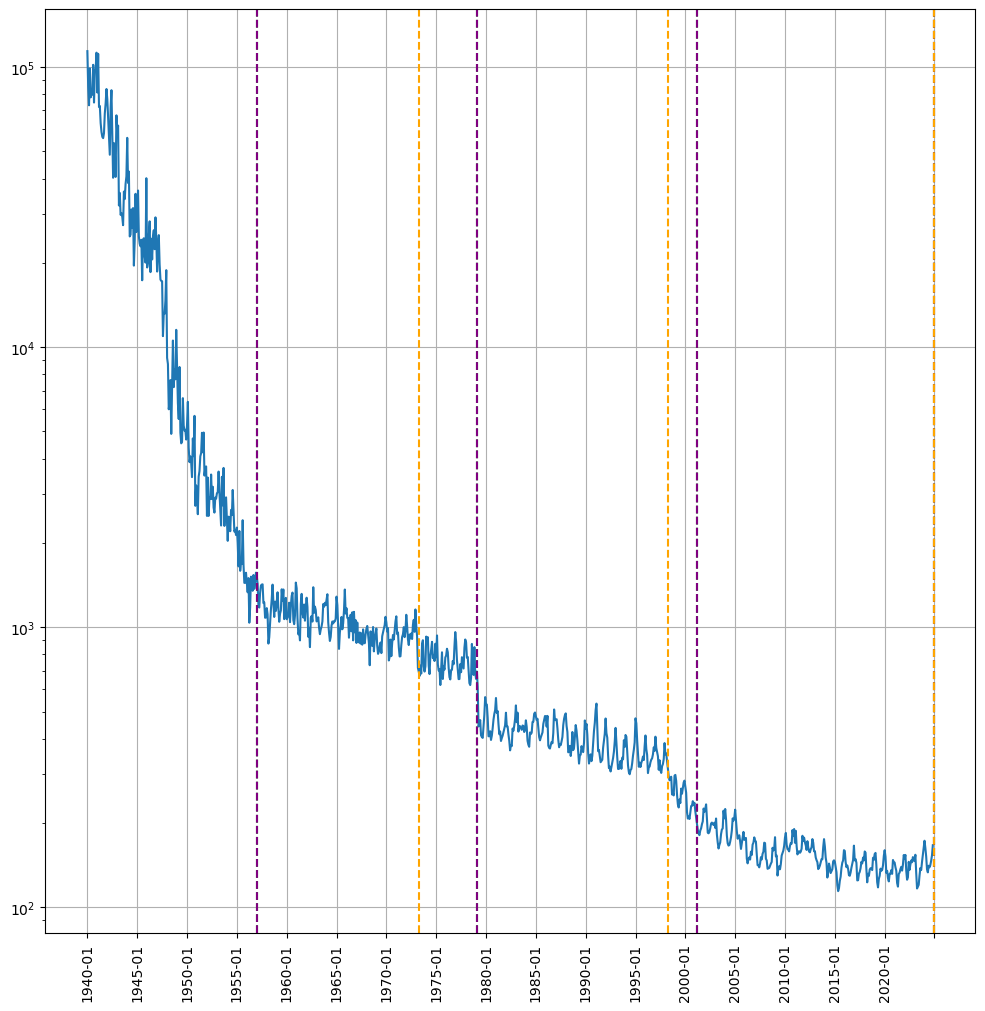

In [74]:

# Create the change point detection model for piecewise linearity (on log scale)
model = "rank"  # l1 is for piecewise linear with L1 norm, good for change detection

# Fit the PELT algorithm
algo = rpt.Pelt(model=model).fit(log_data)

# Use a parameter `pen` to tune the sensitivity
# (change this to adjust the detection threshold)
# You can adjust this value to tune sensitivity (higher = fewer change points)
cps = []
for penalty in [25, 40, 80]:
    change_points = algo.predict(pen=penalty)
    print(f"Penalty: {penalty}, Change points: {change_points}")
    cps.append(change_points)
# Plot the data as a single line
plt.figure(figsize=(12, 12))
plt.plot(time, flattened_data, label='Data')


cols = ['green', 'purple', 'orange']
for i, cp in enumerate(cps):
    for p in cp:
        plt.axvline(x=time[p-1], color=cols[i],
                    linestyle='--', label="Change Point")


# Set log scale for the y-axis
plt.yscale('log')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(MaxNLocator(
    nbins=20))
plt.grid(True)


plt.show()

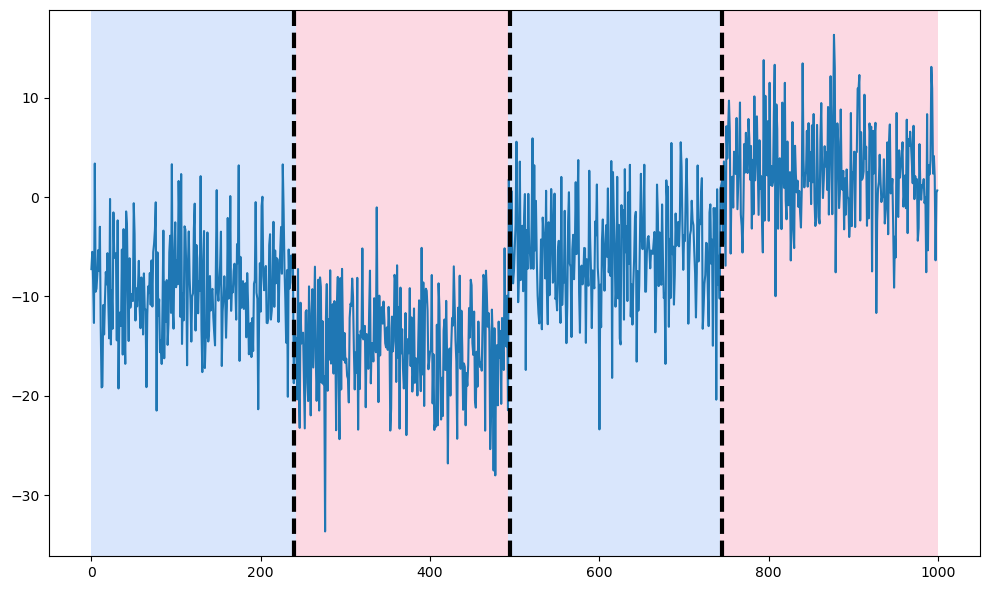

In [82]:
n = 1000  # number of samples
n_bkps, sigma = 3, 5  # number of change points, noise standard deviation
signal, bkps = rpt.pw_constant(n, 1, n_bkps, noise_std=sigma)
# change point detection
model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
algo = rpt.Binseg(model=model).fit(signal)
my_bkps = algo.predict(n_bkps=3)

# show results
rpt.show.display(signal, bkps, my_bkps, figsize=(10, 6))
plt.show()

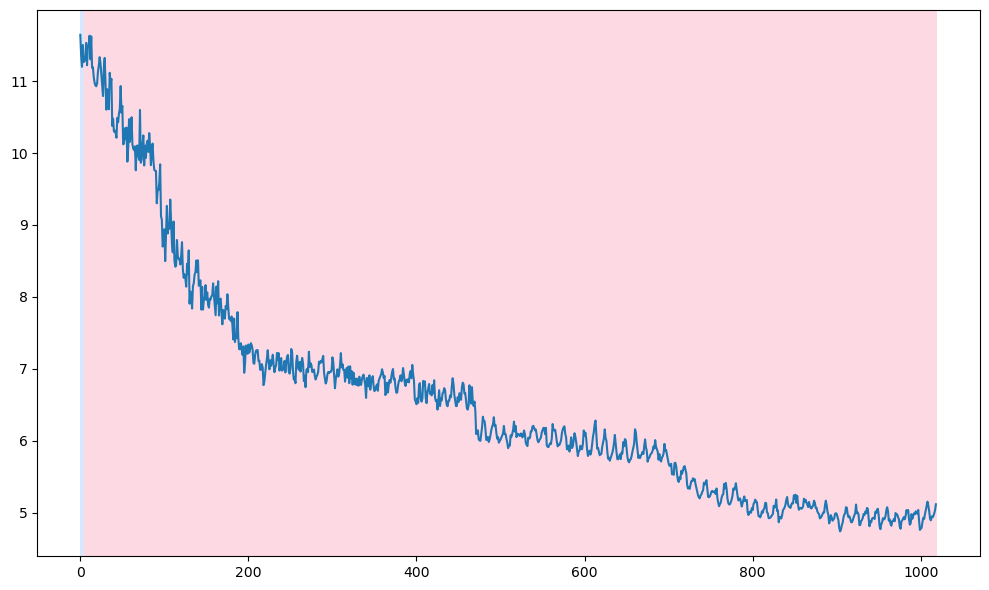

In [83]:
n, n_bkps, sigma = 1000, 4, 5  # number of change points, noise standard deviation
signal, bkps = rpt.pw_constant(n, 1, n_bkps, noise_std=sigma)
model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
algo = rpt.Binseg(model=model).fit(log_data)
my_bkps = algo.predict(n_bkps=5)
# bkps = algo.predict(pen=.01)
# show results
rpt.display(log_data, my_bkps, figsize=(10, 6))
plt.show()

Detected breakpoints (PELT, L2): [95, 180, 470, 595, 1020]


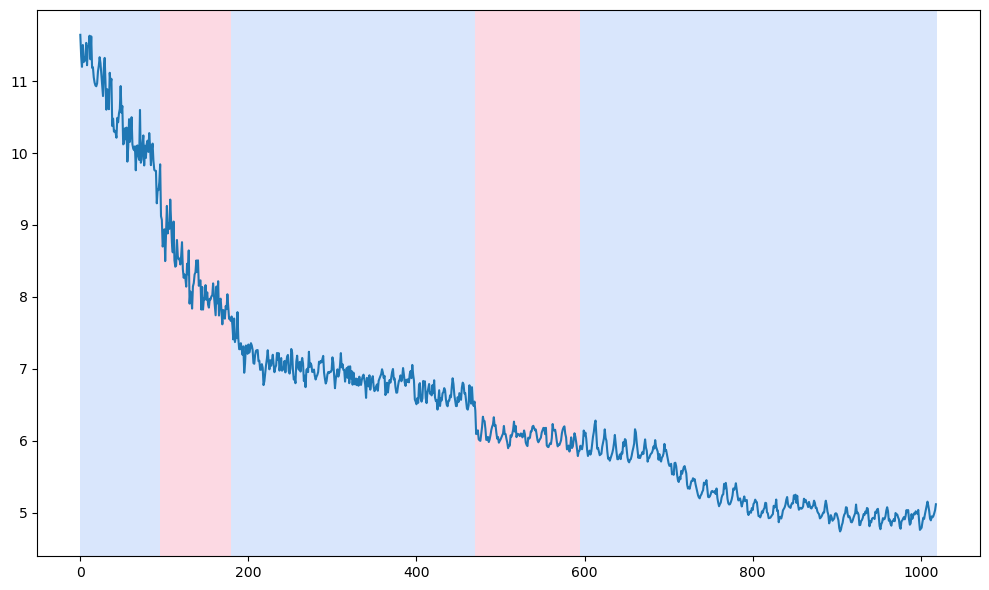

In [38]:
algo_pelt = rpt.Pelt(model="l2").fit(log_data)
# Using the same penalty for consistency; tune this as needed.
penalty_value = 50
bkps_pelt = algo_pelt.predict(pen=penalty_value)
print("Detected breakpoints (PELT, L2):", bkps_pelt)

rpt.display(log_data, bkps_pelt, figsize=(10, 6))
plt.show()

1
[5, 1020]
2
[5, 1020]
3
[5, 1020]
4
[5, 1020]


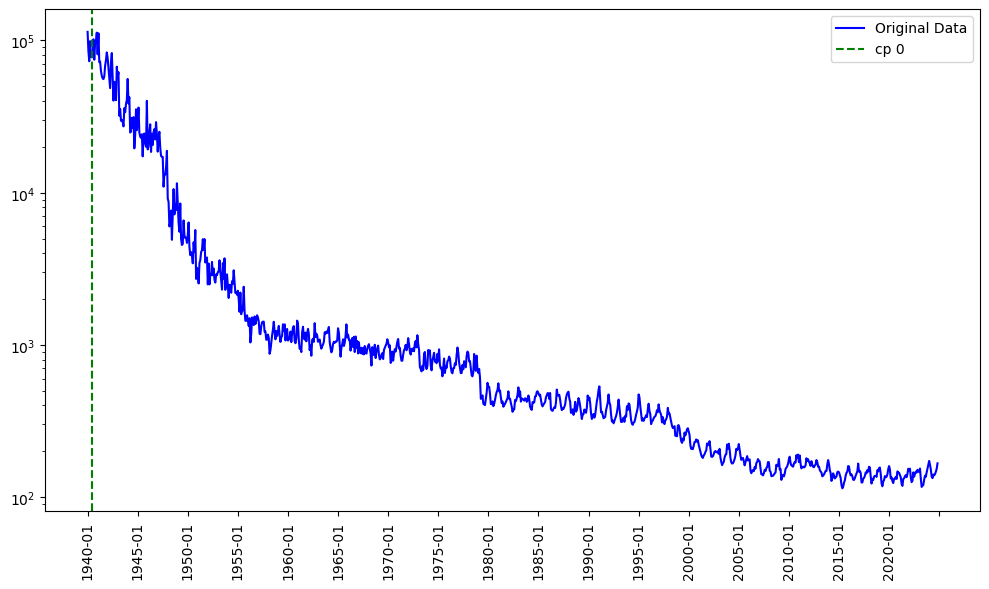

Detected change points at times: [np.str_('1940-06')]


In [70]:
from more_itertools import flatten


plt.figure(figsize=(10, 6))

# Original data
plt.plot(time, flattened_data, label='Original Data', color='blue')

# Step 3: Apply binary segmentation
# Use the 'l2' model for piecewise constant changes
algo = rpt.Binseg(model="l2").fit(np.log(flattened_data**2))

# Specify maximum number of change points (no penalty tuning required)
cps = []
cols = ['green', 'purple', 'orange', 'red', 'brown', 'pink', 'gray']

for i, max_change_points in enumerate([1, 2, 3, 4]):  # , 5, 6]):
    print(max_change_points)
    change_points = algo.predict(n_bkps=max_change_points)
    print(change_points)
    for p in change_points:
        if p not in cps:
            if p < len(time):
                plt.axvline(x=time[p], color=cols[i],
                            linestyle='--', label=f"cp {i}")
                cps.append(p)

# Formatting
plt.yscale('log')  # Retain log scale for visualization
plt.xticks(rotation=90)
plt.tight_layout()
plt.gca().xaxis.set_major_locator(MaxNLocator(
    nbins=20))
plt.legend()
plt.show()

# Step 5: Print detected change points in time format
print("Detected change points at times:", [
      time[cp] for cp in change_points if cp < len(time)])

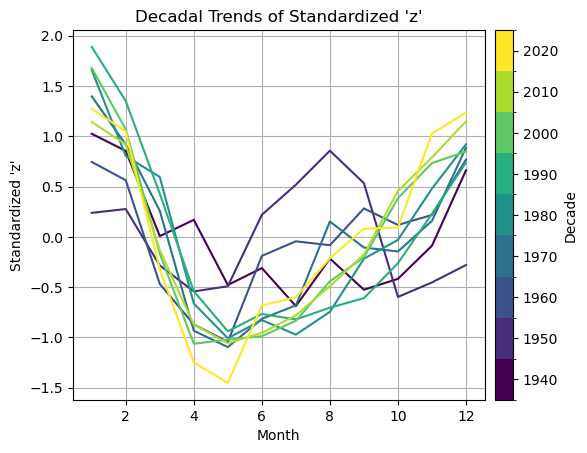

In [18]:
def standardizeByYear(ds):
    """
    Standardize the variable 'z' for each year.
    Subtract the mean and divide by the standard deviation.
    """
    # Standardizing per year
    dss = (
        ds - ds.mean(dim='month')) / ds.std(dim='month')
    return dss


def aggregateToDecade(ds):
    """
    Aggregate the standardized data to the decade level by averaging.
    Adds a 'decade' coordinate for grouping.
    """
    # Adding a 'decade' coordinate
    ds = ds.assign_coords(decade=(ds['year'] // 10) * 10)
    # Grouping by decade and taking the mean
    return ds.groupby('decade').mean(dim='year')


def plotDecadalTrends(ds):
    """
    Plot the standardized 'z' over months with line colors determined by a color bar.
    """
    # Define a colormap for the decades
    decades = np.sort(np.unique(ds['decade'].values))
    cmap = plt.get_cmap("viridis", len(decades))
    color_dict = {dec: cmap(i) for i, dec in enumerate(decades)}

    # Plot lines with colors based on the colormap
    f, ax = plt.subplots()
    for decade in decades:
        ax.plot(
            ds['month'], ds.sel(decade=decade),
            color=color_dict[decade], label=f"{decade}s"
        )

    boundaries = np.arange(len(decades) + 1) - 0.5
    norm = mcolors.BoundaryNorm(boundaries, len(decades))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # This is needed for the ScalarMappable
    cbar = plt.colorbar(sm, ticks=np.arange(len(decades)),
                        orientation='vertical', pad=0.02, ax=ax)

    # Set the tick labels on the colorbar to the actual decade values
    cbar.ax.set_yticklabels(decades)
    cbar.set_label('Decade')

    # Add labels, title, grid, and legend
    ax.set_xlabel("Month")
    ax.set_ylabel("Standardized 'z'")
    ax.set_title("Decadal Trends of Standardized 'z'")
    ax.grid(True)

    plt.show()


# Step 1: Standardize the data by year
stdAvg = [standardizeByYear(ds) for ds in monthlyAverages]

combDataset = combineDatasets(stdAvg, years)

# Step 2: Aggregate the standardized data to the decade level
decadalDataset = aggregateToDecade(combDataset)

# Step 3: Plot decadal trends
plotDecadalTrends(decadalDataset)

## Ensemble spread = f(year, month, x, weather) but mostly f(year)

- find appropriate statistical model for this
- Obtaining observation uncertainty from ecmwf might be helpful, but is global
- subtract control?
    - yes: correlation btw spread and anomaly?
    - no: correlation btw spread and pressure patterns?

### Assumption:

$$x \sim \mathcal{N}(\mu, \sigma); \, \\ 
\mu \sim \text{year} + \sin(\text{doy}) +
\cos(\text{doy} + seg), \, \\
\ln (\sigma) \sim \text{year} + \sin(\text{doy} + seg) +
\cos(\text{doy})$$

in each section

In [3]:

ds = xr.open_dataset(dataPath + 'data.nc',
                     chunks={"longitude": "auto", "latitude": "auto"})
ds.info()

xarray.Dataset {
dimensions:
	number = 10 ;
	time = 31013 ;
	latitude = 141 ;
	longitude = 241 ;

variables:
	int64 number(number) ;
		number:long_name = ensemble member numerical id ;
		number:units = 1 ;
		number:standard_name = realization ;
	datetime64[ns] time(time) ;
		time:long_name = initial time of forecast ;
		time:standard_name = forecast_reference_time ;
	timedelta64[ns] step() ;
		step:long_name = time since forecast_reference_time ;
		step:standard_name = forecast_period ;
	float64 isobaricInhPa() ;
		isobaricInhPa:long_name = pressure ;
		isobaricInhPa:units = hPa ;
		isobaricInhPa:positive = down ;
		isobaricInhPa:stored_direction = decreasing ;
		isobaricInhPa:standard_name = air_pressure ;
	float64 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:standard_name = latitude ;
		latitude:long_name = latitude ;
		latitude:stored_direction = decreasing ;
	float64 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:standard_name = longitud

In [ ]:
ds_anom = ds.isel(number=ds.number != 0) - ds.isel(number=0)
ds_anom.info()

xarray.Dataset {
dimensions:
	number = 9 ;
	time = 31013 ;
	latitude = 141 ;
	longitude = 241 ;

variables:
	int64 number(number) ;
		number:long_name = ensemble member numerical id ;
		number:units = 1 ;
		number:standard_name = realization ;
	datetime64[ns] time(time) ;
		time:long_name = initial time of forecast ;
		time:standard_name = forecast_reference_time ;
	timedelta64[ns] step() ;
		step:long_name = time since forecast_reference_time ;
		step:standard_name = forecast_period ;
	float64 isobaricInhPa() ;
		isobaricInhPa:long_name = pressure ;
		isobaricInhPa:units = hPa ;
		isobaricInhPa:positive = down ;
		isobaricInhPa:stored_direction = decreasing ;
		isobaricInhPa:standard_name = air_pressure ;
	float64 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:standard_name = latitude ;
		latitude:long_name = latitude ;
		latitude:stored_direction = decreasing ;
	float64 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:standard_name = longitude

In [ ]:
ds_anom['year'] = ('time', ds_anom['time.year'].values)
ds_anom['doy'] = ('time', ds_anom['time.dayofyear'].values)
ds_anom['sin_doy'] = ('time', np.sin(2 * np.pi * ds_anom['doy'].values / 365))
ds_anom['cos_doy'] = ('time', np.cos(2 * np.pi * ds_anom['doy'].values / 365))

In [68]:
cp_str = ['1955-01-01T12:00', '1998-05-01T12:00', '1947-12-01T12:00',
          '1979-03-01T12:00']
cp_dates = np.array(
    [np.datetime64(date) for date in cp_str])
cp_dates.sort()

In [ ]:
latitudes = ds_anom['latitude']
longitudes = ds_anom['longitude']
models = {}

grid_data = ds_anom.sel(latitude=latitudes[0], longitude=longitudes[0])
grid_data = grid_data.sel(time=slice(cp_dates[3], None))

# for i in range(len(cp_dates) + 1):
#     if i == 0:  # First segment (start to first change point)
#         segment = grid_data.sel(time=slice(None, cp_dates[i]))
#     elif i == len(cp_dates):  # Last segment (last change point to end)
#         segment = grid_data.sel(time=slice(cp_dates[i - 1], None))
#     else:  # Middle segments (between consecutive change points)
#         segment = grid_data.sel(time=slice(cp_dates[i - 1], cp_dates[i]))

In [70]:
grid_data.info()

xarray.Dataset {
dimensions:
	number = 9 ;
	time = 9708 ;

variables:
	int64 number(number) ;
		number:long_name = ensemble member numerical id ;
		number:units = 1 ;
		number:standard_name = realization ;
	datetime64[ns] time(time) ;
		time:long_name = initial time of forecast ;
		time:standard_name = forecast_reference_time ;
	timedelta64[ns] step() ;
		step:long_name = time since forecast_reference_time ;
		step:standard_name = forecast_period ;
	float64 isobaricInhPa() ;
		isobaricInhPa:long_name = pressure ;
		isobaricInhPa:units = hPa ;
		isobaricInhPa:positive = down ;
		isobaricInhPa:stored_direction = decreasing ;
		isobaricInhPa:standard_name = air_pressure ;
	float64 latitude() ;
		latitude:units = degrees_north ;
		latitude:standard_name = latitude ;
		latitude:long_name = latitude ;
		latitude:stored_direction = decreasing ;
	float64 longitude() ;
		longitude:units = degrees_east ;
		longitude:standard_name = longitude ;
		longitude:long_name = longitude ;
	datetime64[ns] 

In [71]:

z_values = grid_data['z'].values  # Shape: (number, time)
year = grid_data['year'].values[:, np.newaxis]  # Temporal predictors
sin_doy = grid_data['sin_doy'].values[:, np.newaxis]
cos_doy = grid_data['cos_doy'].values[:, np.newaxis]
n_members = z_values.shape[0]
n_time = z_values.shape[1]
predictors = np.hstack([
    np.ones((n_members * n_time, 1)),  # Intercept, repeated for all samples
    # Broadcast year for each ensemble member
    np.tile(year, (n_members, 1)),
    # Broadcast sin_doy for each ensemble member
    np.tile(sin_doy, (n_members, 1)),
    # Broadcast cos_doy for each ensemble member
    np.tile(cos_doy, (n_members, 1))
])

In [84]:
def negativeLogLikelihood(params, data, predictors):
    """
    Negative log-likelihood for Gaussian model with mean and variance predictors.

    Args:
        params (array): Model parameters [beta_0, beta_1, ..., gamma_0, gamma_1, ...].
        data (array): Observed values of the random process.
        predictors (array): Design matrix of predictors (columns: intercept, year, sin(doy), cos(doy)).

    Returns:
        float: Negative log-likelihood value.
    """
    n_predictors = predictors.shape[1]
    beta = params[:n_predictors]  # Mean coefficients
    gamma = params[n_predictors:]  # Variance coefficients

    # Calculate mean and log-variance
    mu = np.dot(predictors, beta)
    log_variance = np.dot(predictors, gamma)
    # log_variance = np.clip(log_variance, -500, 500)
    variance = np.exp(log_variance)

    # Negative log-likelihood
    nll = 0.5 * np.sum(np.log(2 * np.pi * variance) +
                       ((data - mu)**2) / variance)
    return nll

In [85]:
# Initial parameter guess
n_predictors = predictors.shape[1]
initial_params = np.zeros(2 * n_predictors)
nll = negativeLogLikelihood(initial_params, z_values.flatten(), predictors)
print(nll)

14466801.42535672


In [86]:

# Minimize the negative log-likelihood
result = minimize(
    negativeLogLikelihood,
    initial_params,
    args=(z_values.flatten(), predictors),
    method="BFGS",
    options={"disp": False}
)


# Extract fitted parameters
fitted_params = result.x
beta_hat = fitted_params[:n_predictors]
gamma_hat = fitted_params[n_predictors:]

print("Fitted Mean Coefficients:", beta_hat)
print("Fitted Variance Coefficients:", gamma_hat)
print("Fitted Negative Log-Likelihood:", result.fun)
print("Optimization Status:", result.message)
print("Number of Iterations:", result.nit)

/tmp/ipykernel_61799/3572938346.py:21: RuntimeWarning: overflow encountered in exp
  variance = np.exp(log_variance)
/home/schoelleh96/mambaforge/envs/wp22a/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/tmp/ipykernel_61799/3572938346.py:21: RuntimeWarning: overflow encountered in exp
  variance = np.exp(log_variance)
/tmp/ipykernel_61799/3572938346.py:24: RuntimeWarning: divide by zero encountered in log
  nll = 0.5 * np.sum(np.log(2 * np.pi * variance) +
/tmp/ipykernel_61799/3572938346.py:25: RuntimeWarning: divide by zero encountered in divide
  ((data - mu)**2) / variance)
/tmp/ipykernel_61799/3572938346.py:25: RuntimeWarning: overflow encountered in divide
  ((data - mu)**2) / variance)
/tmp/ipykernel_61799/3572938346.py:24: RuntimeWarning: invalid value encountered in add
  nll = 0.5 * np.sum(np.log(2 * np.pi * variance) +
/tmp/ipykernel_61799/3572938346.py:21: RuntimeWarning: overflow encoun

Fitted Mean Coefficients: [-7.30813543e+01 -1.50370009e+05  3.41533237e+02  1.77757808e+02]
Fitted Variance Coefficients: [ 5.94380073e+02 -2.31447309e+02  9.74830307e+05 -1.21719832e+05]
Fitted Negative Log-Likelihood: nan
Optimization Status: Desired error not necessarily achieved due to precision loss.
Number of Iterations: 3


/tmp/ipykernel_61799/3572938346.py:24: RuntimeWarning: divide by zero encountered in log
  nll = 0.5 * np.sum(np.log(2 * np.pi * variance) +
/tmp/ipykernel_61799/3572938346.py:25: RuntimeWarning: divide by zero encountered in divide
  ((data - mu)**2) / variance)
/tmp/ipykernel_61799/3572938346.py:25: RuntimeWarning: overflow encountered in divide
  ((data - mu)**2) / variance)
/tmp/ipykernel_61799/3572938346.py:24: RuntimeWarning: invalid value encountered in add
  nll = 0.5 * np.sum(np.log(2 * np.pi * variance) +
/tmp/ipykernel_61799/3572938346.py:21: RuntimeWarning: overflow encountered in exp
  variance = np.exp(log_variance)
/tmp/ipykernel_61799/3572938346.py:24: RuntimeWarning: overflow encountered in multiply
  nll = 0.5 * np.sum(np.log(2 * np.pi * variance) +
/tmp/ipykernel_61799/3572938346.py:21: RuntimeWarning: overflow encountered in exp
  variance = np.exp(log_variance)
/tmp/ipykernel_61799/3572938346.py:24: RuntimeWarning: divide by zero encountered in log
  nll = 0.5 * np

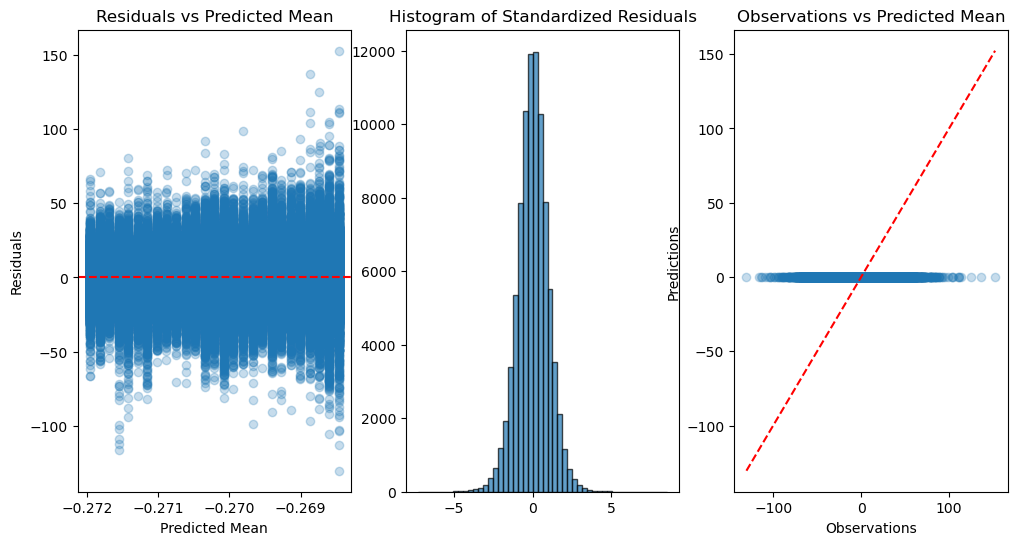

In [75]:
# Predicted mean and variance
predicted_mean = np.dot(predictors, beta_hat)
predicted_log_variance = np.dot(predictors, gamma_hat)
predicted_variance = np.exp(predicted_log_variance)

# Residuals
residuals = z_values.flatten() - predicted_mean
standardized_residuals = residuals / np.sqrt(predicted_variance)

# Plot diagnostics

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(predicted_mean, residuals, alpha=0.25)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Mean')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Mean')

plt.subplot(1, 3, 2)
plt.hist(standardized_residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Standardized Residuals')

plt.subplot(1, 3, 3)
plt.scatter(z_values.flatten(), predicted_mean, alpha=0.25)
min_value = min(z_values.flatten().min(), predicted_mean.min())
max_value = max(z_values.flatten().max(), predicted_mean.max())
plt.plot([min_value, max_value], [min_value, max_value],
         color='red', linestyle='--')
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('Observations vs Predicted Mean')
plt.show()

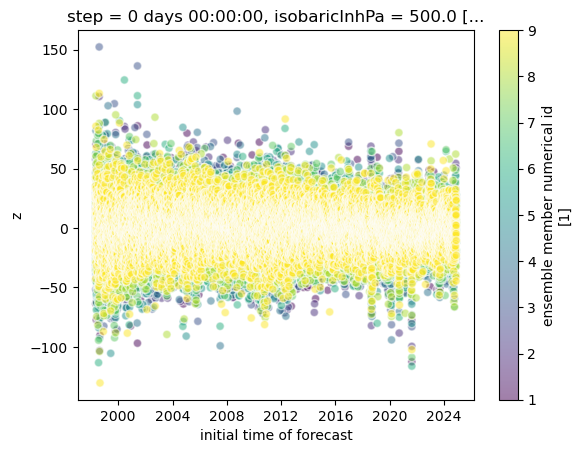

In [78]:
grid_data.plot.scatter(x='time', y='z', hue='number', alpha=0.5)
plt.show()

In [79]:
var = grid_data['z'].var(dim='number').values.flatten()
rss_var = np.sum((var - predicted_variance[:var.shape[0]]) ** 2)

# Step 4: Compute the total sum of squares of variance (TSS_var)
tss_var = np.sum((var - var.mean()) ** 2)

# Step 5: Compute the explained variance of the variance (R_var^2)
r_var_squared = 1 - (rss_var / tss_var)
print("Explained Variance of Variance (R_var^2):", r_var_squared)

Explained Variance of Variance (R_var^2): -0.340327460827923


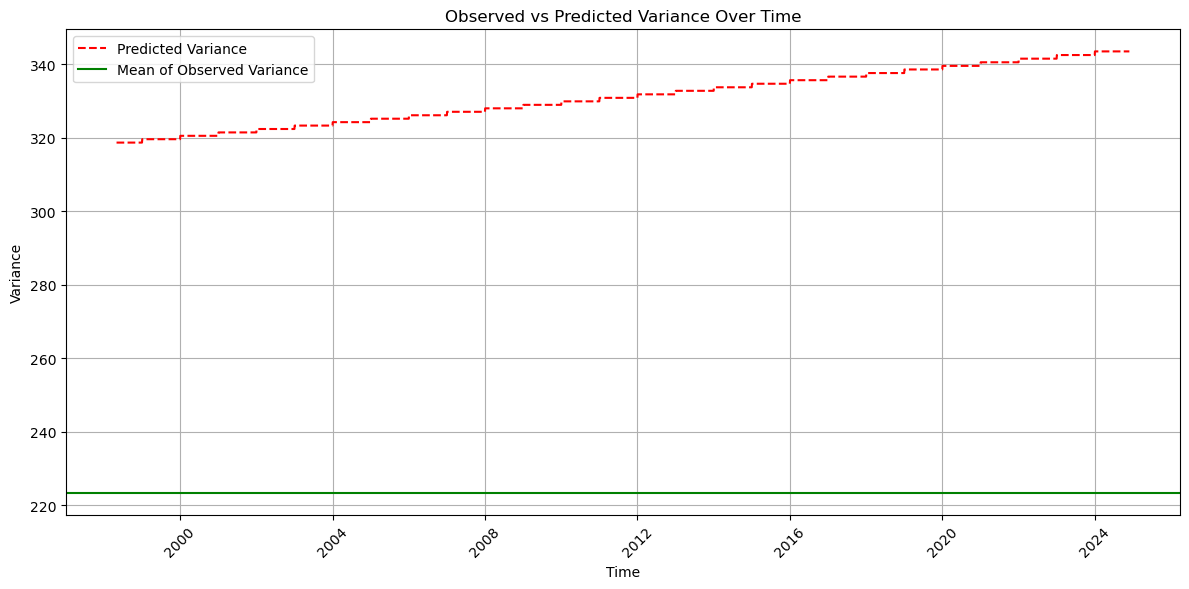

In [83]:
# Ensure the time variable is defined
time = grid_data['time'].values

# Calculate the mean of var
mean_var = np.mean(var)

# Plot the variance and predicted variance
plt.figure(figsize=(12, 6))
# plt.plot(time, var, label='Observed Variance', color='blue')
plt.plot(time, predicted_variance[:var.shape[0]],
         label='Predicted Variance', color='red', linestyle='--')
plt.axhline(mean_var, color='green', linestyle='-',
            label='Mean of Observed Variance')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('Observed vs Predicted Variance Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Observations:
- minimization does not seem to work: variance explodes
- modelling mean seems senseless bc. there is no trend
- sample size of 9 is pretty small anyways so why even bother?
- **New objective:** Model ensemble spread directly
- after controlling for model spread, investigate mean and see if synoptics make a difference

# Fit a cascade of statistical models of varying complexity to the inter-ensemble variance

## Plotting Functions

In [3]:
def plot_model_fit(df, y_pred, x_col, y_col, segment=None, option="time",
                   conf_int=None):
    """
    Function to plot the observed vs predicted data with two options:

    Option 1: Plot against time with quartiles and confidence intervals.
    Option 2: Plot actual vs predicted values with a scatter plot and x=y line.

    Parameters:
    - df: pandas DataFrame containing the original data.
    - y_pred: Fitted (predicted) values from the model.
    - x_col: The column name of the independent variable (features).
    - y_col: The column name of the dependent variable (target).
    - segment: Optional array-like, if you want to color points by segment.
    - option: 1 or 2, specifies which type of plot to generate.
    - conf_int: Tuple (lower, upper) for confidence intervals, required for
    Option 1.
    """

    if option == "time":
        # Option 1: Plot against time with scatter and quartiles

        # Monthly quartiles of the observed data
        df['month'] = df['time'].dt.month  # Extract month from time
        quartiles = df.groupby('month')[y_col].quantile(
            [0.25, 0.5, 0.75]).unstack()

        plt.figure(figsize=(10, 6))

        # Plot actual data as a scatter plot with low alpha
        plt.scatter(df['time'], df[y_col], label='Observed',
                    color='blue', alpha=0.2)

        # Plot the monthly quartiles (25th, 50th, and 75th percentiles)
        plt.plot(quartiles.index,
                 quartiles[0.25], label='25th percentile', color='orange',
                 linestyle='--')
        plt.plot(quartiles.index,
                 quartiles[0.5], label='Median', color='orange',
                 linestyle='--')
        plt.plot(quartiles.index,
                 quartiles[0.75], label='75th percentile', color='orange',
                 linestyle='--')

        # Plot the predicted data with confidence intervals
        if conf_int is not None:
            lower, upper = conf_int
            plt.fill_between(df['time'], lower, upper, color='lightgray',
                             alpha=0.5, label='Confidence Interval')
        plt.plot(df['time'], y_pred,
                 label='Fitted (Predicted)', color='black', linewidth=2)

        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.title(
            f'{y_col} Over Time with Monthly Quartiles & Confidence Intervals')
        plt.legend()
        plt.grid(True)
        plt.show()

    elif option == "corr":
        # Option 2: Actual vs predicted values with x=y line and segment coloring

        if segment is not None:
            # Segment coloring: color by segment
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(
                df[x_col], y_pred, c=segment, cmap='Set1', alpha=0.6)
            plt.colorbar(scatter, label='Segment Index')
        else:
            plt.figure(figsize=(8, 6))
            plt.scatter(df[x_col], y_pred,
                        label='Predicted vs Actual', color='blue', alpha=0.6)

        # Add y=x line (diagonal line)
        plt.plot([df[x_col].min(), df[x_col].max()],
                 [df[x_col].min(), df[x_col].max()],
                 color='red', linestyle='--', label='y = x')

        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title(f'Actual vs Predicted: {y_col} vs {x_col}')
        plt.legend()
        plt.grid(True)
        plt.show()

## Procure Data

In [4]:
ds = xr.open_dataset(dataPath + 'data.nc').isel(latitude=0,
                                                longitude=0)
ds_var = ds.isel(number=ds.number != 0) - ds.isel(number=0)

# Calculate the variance over the "number" dimension before converting to DataFrame
ds_var['var'] = ds_var['z'].var(dim='number')

# Convert the DataArray to a DataFrame
df_var = ds_var['var'].to_dataframe().reset_index()

# Add the log-transformed variance as a new column
df_var['log_var'] = np.log(df_var['var'])

# Add year and day of year (doy) as new columns
df_var['year'] = df_var['time'].dt.year
df_var['doy'] = df_var['time'].dt.dayofyear

# Add sine and cosine of day of year (for seasonal components)
df_var['sin_doy'] = np.sin(2 * np.pi * df_var['doy'] / 365)
df_var['cos_doy'] = np.cos(2 * np.pi * df_var['doy'] / 365)

# Change points (converting strings to datetime)
cp_str = ['1947-12-01T12:00', '1955-01-01T12:00',
          '1979-03-01T12:00', '1998-05-01T12:00']
change_points = pd.to_datetime(cp_str)

# Add the start and end of the time coordinate to the breaks
breaks = np.concatenate(([df_var['time'].values[0]], change_points,
                         [df_var['time'].values[-1]]))
breaks_numeric = pd.to_datetime(breaks).astype(
    np.int64) // 10**9  # Convert to seconds
time_numeric = pd.to_datetime(
    df_var['time'].values).astype(np.int64) // 10**9

# Find the segment index for each time point
segment_indices = np.digitize(time_numeric, breaks_numeric, right=False) - 1
segment_indices[segment_indices == len(breaks) - 1] = len(breaks) - 2

# Add the segment index as a new column
df_var['segment'] = segment_indices

# Display the resulting DataFrame
print(df_var.head())

                 time   step  isobaricInhPa  latitude  longitude  \
0 1940-01-01 12:00:00 0 days          500.0      90.0     -100.0   
1 1940-01-02 12:00:00 0 days          500.0      90.0     -100.0   
2 1940-01-03 12:00:00 0 days          500.0      90.0     -100.0   
3 1940-01-04 12:00:00 0 days          500.0      90.0     -100.0   
4 1940-01-05 12:00:00 0 days          500.0      90.0     -100.0   

           valid_time            var    log_var  year  doy   sin_doy  \
0 1940-01-01 12:00:00  197668.484375  12.194346  1940    1  0.017213   
1 1940-01-02 12:00:00  449105.843750  13.015014  1940    2  0.034422   
2 1940-01-03 12:00:00  303560.562500  12.623337  1940    3  0.051620   
3 1940-01-04 12:00:00  122023.484375  11.711968  1940    4  0.068802   
4 1940-01-05 12:00:00  394983.593750  12.886600  1940    5  0.085965   

    cos_doy  segment  
0  0.999852        0  
1  0.999407        0  
2  0.998667        0  
3  0.997630        0  
4  0.996298        0  


## Simplest model: lm no segments

In [5]:
# Define the independent (X) and dependent (y) variables
X = sm.add_constant(df_var['year'])  # Adds intercept term
y = df_var['log_var']

# Fit the model
model = sm.OLS(y, X).fit()

# Display the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_var   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                 9.504e+04
Date:                Thu, 09 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:07:52   Log-Likelihood:                -45942.
No. Observations:               31013   AIC:                         9.189e+04
Df Residuals:                   31011   BIC:                         9.190e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        157.7532      0.489    322.734      0.0

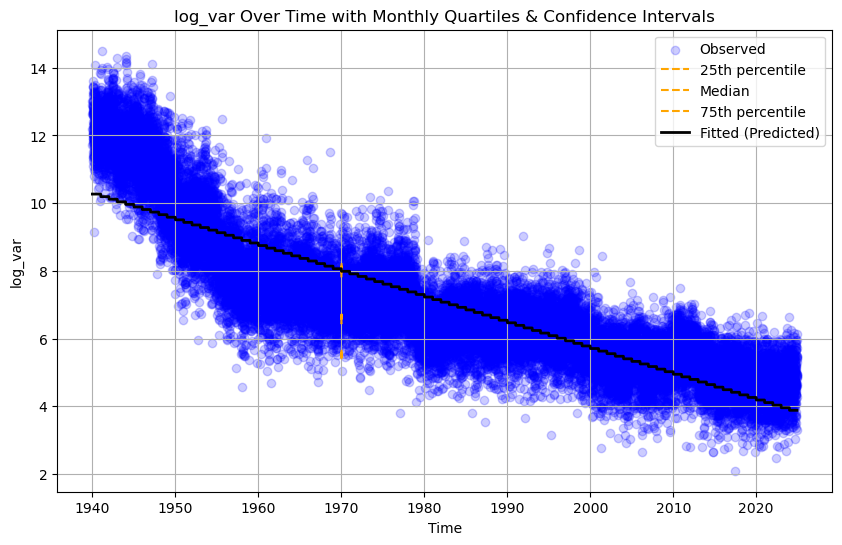

In [6]:
X_pred = sm.add_constant(df_var['year'])
predictions = model.get_prediction(X)

# Extract the predicted values
y_pred = predictions.predicted_mean

# Extract the confidence intervals (lower and upper)
conf_int = predictions.conf_int(alpha=0.05)  # 95% confidence intervals
lower_bound = conf_int[:, 0]
upper_bound = conf_int[:, 1]
plot_model_fit(
    df_var, y_pred, 'year', 'log_var', option="time",
    conf_int=None)